# Emotion Classification using Text

## Context
Detect emotions (HAPPY, SAD, FEAR, ANGRY, DISGUST, SURPRISE, NEUTRAL) from the text

### Data:
- The Interactive Emotional Dyadic Motion Capture (IEMOCAP) database is an acted, multimodal and multi speaker database, collected at SAIL lab at USC. 


### Import Statements

In [47]:
import argparse
import pickle
import sys

import numpy as np

seed = 1234

np.random.seed(seed)
import tensorflow as tf
from tqdm import tqdm

from model import LSTM_Model

from sklearn.metrics import f1_score

tf.set_random_seed(seed)


### Reading the data and training using LSTM with attention

In [ ]:

unimodal_activations = {}

train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []

def unimodal(mode, data, classes):
    print(('starting unimodal ', mode))

    if data == 'mosei' or data == 'mosi':
        with open('./dataset/{0}/raw/{1}_{2}way.pickle'.format(data, mode, classes), 'rb') as handle:
            u = pickle._Unpickler(handle)
            u.encoding = 'latin1'
            if data == 'mosei':
                (train_data, train_label, _, _, test_data, test_label, _, train_length, _, test_length, _, _,
                 _) = u.load()
                if classes == '2':
                    train_label, test_label = createOneHotMosei2way(train_label, test_label)
            elif data == 'mosi':
                (train_data, train_label, test_data, test_label, maxlen, train_length, test_length) = u.load()
                train_label = train_label.astype('int')
                test_label = test_label.astype('int')
                train_label, test_label = createOneHot(train_label, test_label)
            else:
                raise NotImplementedError('Unknown dataset...')

            train_label = train_label.astype('int')
            test_label = test_label.astype('int')

            train_mask = np.zeros((train_data.shape[0], train_data.shape[1]), dtype='float')
            for i in range(len(train_length)):
                train_mask[i, :train_length[i]] = 1.0

            test_mask = np.zeros((test_data.shape[0], test_data.shape[1]), dtype='float')
            for i in range(len(test_length)):
                test_mask[i, :test_length[i]] = 1.0
    elif data == 'iemocap':
        train_data, test_data, text_train, text_test, video_train, video_test, train_label, test_label, seqlen_train, seqlen_test, train_mask, test_mask = get_raw_data(
            data, classes)
        train_data = text_train
        
    # train_label, test_label = createOneHotMosei3way(train_label, test_label)

    attn_fusion = False

    print('train_mask', train_mask.shape)

    # print(train_mask_bool)
    seqlen_train = np.sum(train_mask, axis=-1)
    print('seqlen_train', seqlen_train.shape)
    seqlen_test = np.sum(test_mask, axis=-1)
    print('seqlen_test', seqlen_test.shape)

    allow_soft_placement = True
    log_device_placement = False

    # Multimodal model
    session_conf = tf.ConfigProto(
        # device_count={'GPU': gpu_count},
        allow_soft_placement=allow_soft_placement,
        log_device_placement=log_device_placement,
        gpu_options=tf.GPUOptions(allow_growth=True))
    gpu_device = 0
    best_acc = 0
    best_epoch = 0
    best_loss = 1000000.0
    best_epoch_loss = 0
    is_unimodal = True
    with tf.device('/device:GPU:%d' % gpu_device):
        print('Using GPU - ', '/device:GPU:%d' % gpu_device)
        with tf.Graph().as_default():
            tf.set_random_seed(seed)
            sess = tf.Session(config=session_conf)
            with sess.as_default():
                model = LSTM_Model(train_data.shape[1:], 0.0001, a_dim=0, v_dim=0, t_dim=0, emotions=classes,
                                   attn_fusion=attn_fusion, unimodal=is_unimodal, seed=seed)
                sess.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))

                test_feed_dict = {
                    model.input: test_data,
                    model.y: test_label,
                    model.seq_len: seqlen_test,
                    model.mask: test_mask,
                    model.lstm_dropout: 0.0,
                    model.lstm_inp_dropout: 0.0,
                    model.dropout: 0.0,
                    model.dropout_lstm_out: 0.0

                }
                train_feed_dict = {
                    model.input: train_data,
                    model.y: train_label,
                    model.seq_len: seqlen_train,
                    model.mask: train_mask,
                    model.lstm_dropout: 0.0,
                    model.lstm_inp_dropout: 0.0,
                    model.dropout: 0.0,
                    model.dropout_lstm_out: 0.0

                }
                # print('\n\nDataset: %s' % (data))
                print("\nEvaluation before training:")
                # Evaluation after epoch
                step, loss, accuracy = sess.run(
                    [model.global_step, model.loss, model.accuracy],
                    test_feed_dict)
                print("EVAL: epoch {}: step {}, loss {:g}, acc {:g}".format(0, step, loss, accuracy))

                for epoch in range(epochs):
                    epoch += 1

                    batches = batch_iter(list(
                        zip(train_data, train_mask, seqlen_train, train_label)),
                        batch_size)

                    # Training loop. For each batch...
                    print('\nTraining epoch {}'.format(epoch))
                    l = []
                    a = []
                    for i, batch in tqdm(enumerate(batches)):
                        b_train_data, b_train_mask, b_seqlen_train, b_train_label = zip(
                            *batch)
                        feed_dict = {
                            model.input: b_train_data,
                            model.y: b_train_label,
                            model.seq_len: b_seqlen_train,
                            model.mask: b_train_mask,
                            model.lstm_dropout: 0.4,
                            model.lstm_inp_dropout: 0.0,
                            model.dropout: 0.2,
                            model.dropout_lstm_out: 0.2

                        }

                        _, step, loss, accuracy = sess.run(
                            [model.train_op, model.global_step, model.loss, model.accuracy],
                            feed_dict)
                        l.append(loss)
                        a.append(accuracy)
                    train_accuracy.append(np.average(a))
                    train_loss.append(np.average(l))
                    print("\t \tEpoch {}:, loss {:g}, accuracy {:g}".format(epoch, np.average(l), np.average(a)))
                    # Evaluation after epoch
                    step, loss, accuracy, test_activations = sess.run(
                        [model.global_step, model.loss, model.accuracy, model.inter1],
                        test_feed_dict)
                    loss = loss / test_label.shape[0]
                    print("EVAL: After epoch {}: step {}, loss {:g}, acc {:g}".format(epoch, step, loss, accuracy))
                    val_accuracy.append(accuracy)
                    val_loss.append(loss)
                    if accuracy > best_acc:
                        best_epoch = epoch
                        best_acc = accuracy

                    if epoch == 30:
                        step, loss, accuracy, train_activations = sess.run(
                            [model.global_step, model.loss, model.accuracy, model.inter1],
                            train_feed_dict)
                        unimodal_activations[mode + '_train'] = train_activations
                        unimodal_activations[mode + '_test'] = test_activations

                        unimodal_activations['train_mask'] = train_mask
                        unimodal_activations['test_mask'] = test_mask
                        unimodal_activations['train_label'] = train_label
                        unimodal_activations['test_label'] = test_label

                    if loss < best_loss:
                        best_epoch_loss = epoch
                        best_loss = loss
                    

                print("\n\nBest epoch: {}\nBest test accuracy: {}".format(best_epoch, best_acc))
                print("\n\nBest epoch: {}\nBest test loss: {}".format(best_epoch_loss, best_loss))



In [ ]:

if __name__ == "__main__":
    argv = sys.argv[1:]
    parser = argparse.ArgumentParser()
    parser.add_argument("--unimodal", type=str2bool, nargs='?', const=True, default=True)
    parser.add_argument("--fusion", type=str2bool, nargs='?', const=True, default=False)
    parser.add_argument("--attention_2", type=str2bool, nargs='?', const=True, default=False)
    parser.add_argument("--use_raw", type=str2bool, nargs='?', const=True, default=False)
    parser.add_argument("--data", type=str, default='mosi')
    parser.add_argument("--classes", type=str, default='2')
    args, _ = parser.parse_known_args(argv)

    print(args)

    batch_size = 20
    epochs = 100
    emotions = args.classes
    assert args.data in ['mosi', 'mosei', 'iemocap']

    if args.unimodal:
        print("Training unimodals first")
        unimodal('text', args.data, args.classes)

        print("Saving unimodal activations")
        with open('unimodal_{0}_{1}way.pickle'.format(args.data, args.classes), 'wb') as handle:
            pickle.dump(unimodal_activations, handle, protocol=pickle.HIGHEST_PROTOCOL)

    if not args.use_raw:
        with open('unimodal_{0}_{1}way.pickle'.format(args.data, args.classes), 'rb') as handle:
            u = pickle._Unpickler(handle)
            u.encoding = 'latin1'
            unimodal_activations = u.load()

    
    

### Plotting the Graphs

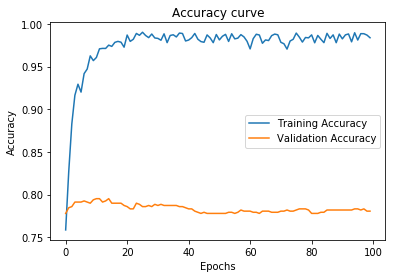

In [45]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Accuracy curve')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='center right')
plt.show()

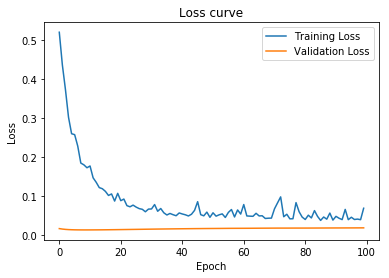

In [46]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper right')
plt.show()